In [1]:
from pathlib import Path

import colorcet as cc
import diffrax as dfx
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from dynamical_systems.continuous import AbstractODE, Lorenz63, TangentODE
from dynamical_systems.transforms import TransformedODE
from dynamics_discovery.data import TimeSeriesDataset
from dynamics_discovery.data.loaders import (
    RandomSampleBatching,
)
from dynamics_discovery.neighborhood import (
    NeighborhoodSegmentLoader,
)
from jaxtyping import Array, Float
from matplotlib_utils.plots import colored_scatterplot


jax.config.update("jax_enable_x64", True)
plt.style.use("matplotlib_utils.styles.dash_gridded")

datadir = Path("../../data")

In [125]:
noise = 0.05
downsample = 2
dataset, transform = (
    TimeSeriesDataset.from_hdf5(datadir / "lorenz63_large.hdf5")
    .downsample(downsample)
    .add_noise(noise)
    .standardize()
)

lorenz_scaled = TransformedODE(Lorenz63(), transform)

dataset.u.shape

(5000, 5000, 3)

In [ ]:
from scipy.spatial import KDTree


u_dataset_flat = dataset.u[:, :-1].reshape(-1, dataset.u.shape[-1])
tree = KDTree(u_dataset_flat)


In [127]:
sample_idx = 30
u_center = dataset.u[sample_idx, 0]
idx_radius = jnp.asarray(tree.query_ball_point(u_center, 0.05))
u_radius = u_dataset_flat[idx_radius]
u_radius.shape

(4526, 3)

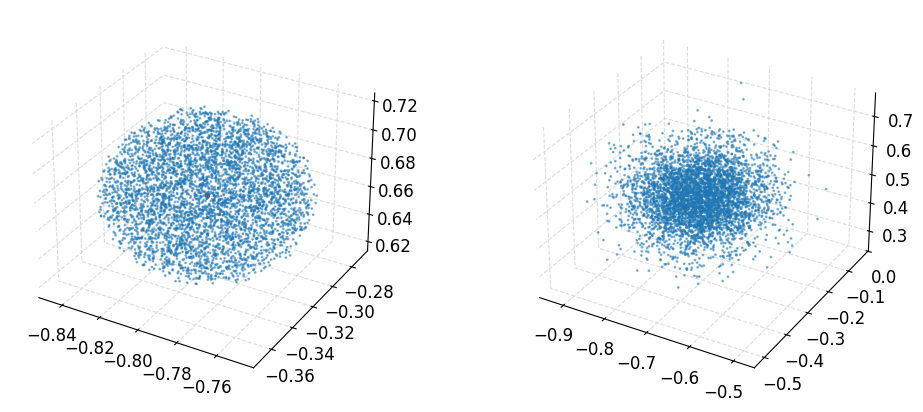

In [131]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={"projection": "3d"})
scatter_kwargs = {"s": 1.0, "alpha": 0.8}
# ax.scatter(*u_dataset_flat[::100].T, **scatter_kwargs)
axes[0].scatter(*dataset.u[sample_idx, 0], color="red", s=8.0)
axes[0].scatter(*u_radius.T, s=1.0, alpha=0.5)

axes[1].scatter(*dataset.u[sample_idx, 1], color="red", s=8.0)
axes[1].scatter(*u_dataset_flat[idx_radius + 1].T, s=1.0, alpha=0.5)

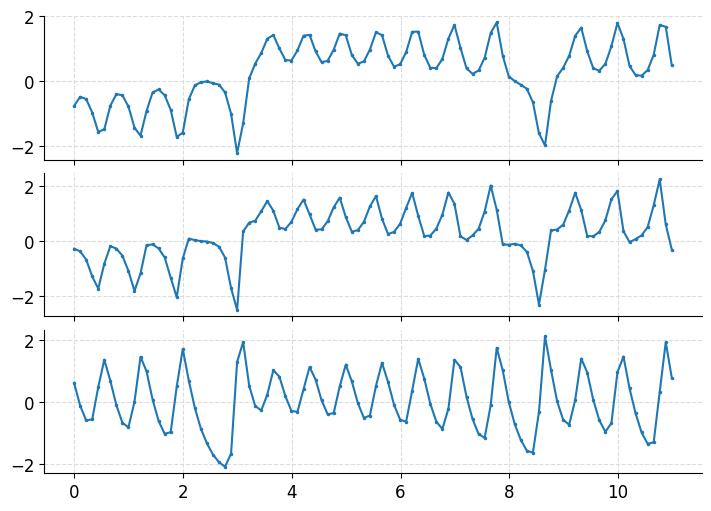

In [90]:
fig, axes = plt.subplots(3, 1, figsize=(7, 5), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(dataset.t[0, :100], dataset.u[0, :100, i], ".-")

In [135]:
num_neighbors = 500
loader = NeighborhoodSegmentLoader(
    dataset, 2, num_neighbors, RandomSampleBatching(batch_size=4)
)
loader_state = loader.init()
batch, loader_state = loader.load_batch(loader_state)

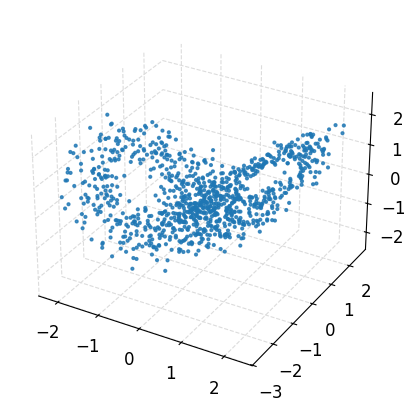

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), subplot_kw={"projection": "3d"})
scatter_kwargs = {"s": 4.0, "alpha": 0.8}
ax.scatter(*batch[1][:, 0].T, **scatter_kwargs)

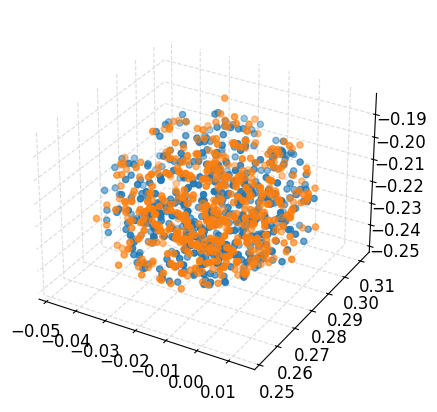

In [136]:
sample_idx = 0
noise = 0.002

u_noise = batch[1] + noise * jax.random.normal(jax.random.key(0), batch[1].shape)
u_nn_noise = batch[2] + noise * jax.random.normal(jax.random.key(1), batch[2].shape)

u0 = batch[1][sample_idx, 0]
u_nn0 = batch[2][sample_idx, 0]

u1 = batch[1][sample_idx, 1]
u_nn1 = batch[2][sample_idx, 1]


fig, ax = plt.subplots(1, 1, figsize=(8, 4), subplot_kw={"projection": "3d"})
ax.scatter(*u_nn0.T)
ax.scatter(*u_nn_noise[sample_idx, 0].T)

In [68]:
u_nn_noise.shape

(1024, 2, 50, 3)

In [137]:
u_noise_all = jnp.concatenate((jnp.expand_dims(u_noise, axis=-2), u_nn_noise), axis=-2)
u_mean = jnp.mean(u_noise_all, axis=-2, keepdims=True)
u_covar = jnp.mean(
    jax.vmap(jax.vmap(jax.vmap(jnp.linalg.outer)))(
        u_noise_all - u_mean, u_noise_all - u_mean
    ),
    axis=-3,
)
eigvals, eigvecs = jnp.linalg.eigh(u_covar)

In [138]:
u_noise_all.shape

(4, 2, 501, 3)

In [139]:
u_resid = u_noise_all - u_mean
u_resid.shape

(4, 2, 501, 3)

In [140]:
eigvecs.shape

(4, 2, 3, 3)

In [141]:
eigvals

Array([[[0.00016807, 0.00018852, 0.00020288],
        [0.00233619, 0.00458253, 0.00576165]],

       [[0.00011969, 0.0001341 , 0.00013593],
        [0.00238312, 0.00436265, 0.00496431]],

       [[0.00012533, 0.00014053, 0.00015414],
        [0.00268185, 0.00528321, 0.00661036]],

       [[0.00011479, 0.00011864, 0.00013462],
        [0.00220165, 0.00473042, 0.00555412]]], dtype=float64)

In [142]:
eigvecs[0, 0, 1]

Array([-0.20306241,  0.83703282,  0.50807648], dtype=float64)

In [143]:
jnp.expand_dims(eigvecs[..., 0], axis=-2).shape

(4, 2, 1, 3)

In [147]:
correction = -jnp.expand_dims(
    jnp.linalg.vecdot(u_resid, jnp.expand_dims(eigvecs[..., 0], axis=-2)), axis=-1
) * jnp.expand_dims(eigvecs[..., 0], axis=-2)
u_noise_corr = u_noise_all + correction

In [149]:
u_noise_corr = (
    jnp.expand_dims(
        jnp.linalg.vecdot(u_resid, jnp.expand_dims(eigvecs[..., 0], axis=-2)), axis=-1
    )
    * jnp.expand_dims(eigvecs[..., 0], axis=-2)
    + jnp.expand_dims(
        jnp.linalg.vecdot(u_resid, jnp.expand_dims(eigvecs[..., 1], axis=-2)), axis=-1
    )
    * jnp.expand_dims(eigvecs[..., 1], axis=-2)
    + u_noise_all
)

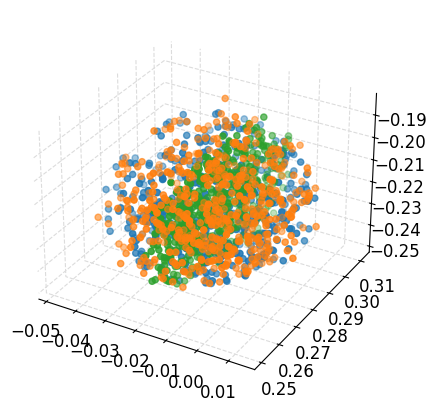

In [148]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), subplot_kw={"projection": "3d"})
ax.scatter(*u_nn0.T)
ax.scatter(*u_nn_noise[sample_idx, 0].T)
ax.scatter(*u_noise_corr[sample_idx, 0, 1:].T)

In [5]:
def tangent_evolution_matrix(
    ode: AbstractODE,
    x: Float[Array, " dim"],
    t0: float,
    t1: float,
    solver: dfx.AbstractAdaptiveSolver = dfx.Tsit5(),
    stepsize_controller: dfx.AbstractAdaptiveStepSizeController = dfx.PIDController(
        rtol=1e-7, atol=1e-9
    ),
):
    tangent_ode = TangentODE(ode)
    u0 = (x, jnp.identity(ode.dim))

    sol = dfx.diffeqsolve(
        dfx.ODETerm(tangent_ode.rhs),
        solver,
        t0,
        t1,
        None,
        u0,
        None,
        saveat=dfx.SaveAt(t1=True),
        stepsize_controller=stepsize_controller,
    )
    _, M_t = sol.ys
    return M_t[0]  # remove time dimension

In [30]:
batch[2].shape

(1024, 2, 50, 3)

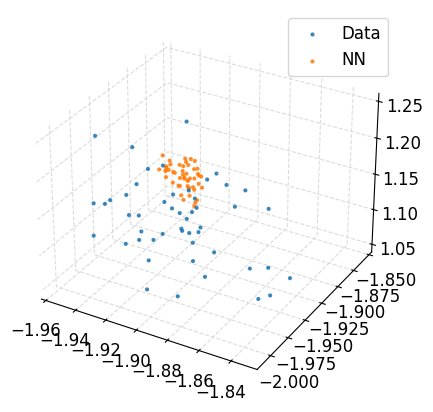

In [31]:
sample_idx = 0

u0 = batch[1][sample_idx, 0]
u_nn0 = batch[2][sample_idx, 0]

u1 = batch[1][sample_idx, 1]
u_nn1 = batch[2][sample_idx, 1]

M = tangent_evolution_matrix(lorenz_scaled, u0, *batch[0][sample_idx])

u_nn1_pred = jnp.squeeze(M @ jnp.expand_dims(u_nn0 - u0, axis=-1)) + u1

fig, ax = plt.subplots(1, 1, figsize=(8, 4), subplot_kw={"projection": "3d"})
scatter_kwargs = {"s": 4.0, "alpha": 0.8}
ax.scatter(*u_nn1.T, label="Data", **scatter_kwargs)
ax.scatter(
    *u_nn1_pred.T,
    label="NN",
    **scatter_kwargs,
)
ax.legend()

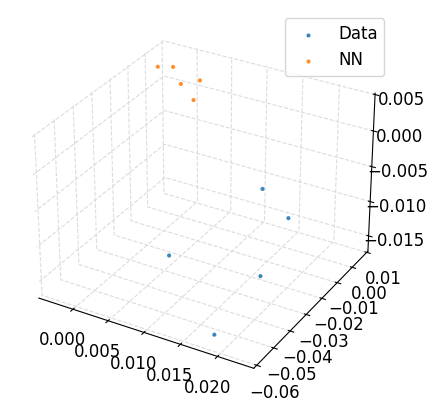

In [32]:
du0 = jnp.expand_dims(u_nn0 - u0, axis=-1)
du0_mean = jnp.mean(du0.reshape(10, -1, 3, 1), axis=0)


du1 = jnp.expand_dims(u_nn1 - u1, axis=-1)
du1_mean = jnp.squeeze(jnp.mean(du1.reshape(10, -1, 3, 1), axis=0))

du_nn1_mean_pred = jnp.squeeze(M @ du0_mean)

fig, ax = plt.subplots(1, 1, figsize=(8, 4), subplot_kw={"projection": "3d"})
scatter_kwargs = {"s": 4.0, "alpha": 0.8}
ax.scatter(*du1_mean.T, label="Data", **scatter_kwargs)
ax.scatter(
    *du_nn1_mean_pred.T,
    label="NN",
    **scatter_kwargs,
)
ax.legend()

In [24]:
u_nn1.shape

(50, 3)

In [140]:
tangent_evolution_matrix(lorenz_scaled, u0, *batch[0][sample_idx])

Array([[-0.50601074,  1.25011664, -2.04192358],
       [-0.71753571,  1.72945967, -2.95083028],
       [-0.4385832 ,  1.27777787, -1.41522471]], dtype=float64)

In [141]:
M_pred = eqx.filter_vmap(
    lambda u_i: tangent_evolution_matrix(
        lorenz_scaled, u_i, 0.0, batch[0][0, 1] - batch[0][0, 0]
    )
)(batch[1][:, 0])

In [142]:
du = jnp.permute_dims(batch[2] - jnp.expand_dims(batch[1], axis=-2), axes=(0, 1, 3, 2))
du.shape

(1024, 2, 3, 30)

In [143]:
M_naive = jnp.matmul(du[:, 1], jnp.linalg.pinv(du[:, 0]))
M_naive.shape

(1024, 3, 3)

In [144]:
jnp.linalg.pinv(du[:, 0])

Array([[[ -0.0809918 ,   0.3437666 ,   1.10603115],
        [ -2.07956028,   3.15355796,  -0.93637402],
        [ -4.68444028,   2.00616249,   0.68229178],
        ...,
        [ -4.84450794,   8.67670708,  -1.30788622],
        [ -0.16980416,   4.3533865 ,   9.27830593],
        [  4.83786147,   3.43134203,   5.30419589]],

       [[ -8.09814275,   6.2030196 ,   0.3732574 ],
        [  6.13399977,  -3.71944934,   2.56858613],
        [ -5.87146136,   0.80789627,  -0.8171408 ],
        ...,
        [ -4.58422295,  -3.42153414,  -5.30516394],
        [  1.15732343,  -9.30410522,  -0.66629122],
        [ -7.76981498,   1.42054553,   6.14952211]],

       [[ -0.99331446,   3.82683081,  -2.06730588],
        [  0.40033583,   5.94456485,  -1.90411291],
        [  0.91100816,   3.80915139,   2.70205953],
        ...,
        [ -0.87264181,   5.2354974 ,  -8.75844341],
        [-13.87605348,   0.13447624,  -2.59251479],
        [ -2.99460584,   6.51111895,   6.00798579]],

       ...,

      

In [213]:
M_pred_norm = jnp.linalg.norm(M_pred, axis=(-2, -1), ord=2)
logerr = jnp.log10(
    jnp.linalg.norm(M_pred - M_naive, axis=(-2, -1), ord=2) / M_pred_norm
)

(array([ 1.,  2.,  6., 13., 24., 28., 41., 35., 23., 27., 25., 24., 29.,
        22., 22., 20., 27., 28., 23., 26., 24., 25., 22., 15., 17., 18.,
        12., 17., 13., 14.,  9., 15., 11., 24., 14., 14., 13., 18., 11.,
        10., 13., 10.,  6.,  9.,  6.,  8., 12., 14., 12.,  8.,  7.,  8.,
         6.,  3., 11., 10.,  6.,  9.,  6.,  4.,  4.,  9.,  7.,  4.,  3.,
         2.,  4.,  1.,  6.,  0.,  7.,  5.,  1.,  1.,  2.,  7.,  3.,  2.,
         4.,  4.,  0.,  3.,  1.,  2.,  1.,  1.,  2.,  0.,  0.,  1.,  1.,
         0.,  2.,  1.,  1.,  1.,  0.,  0.,  0.,  1.]),
 array([-0.00335053,  0.01600816,  0.03536685,  0.05472555,  0.07408424,
         0.09344293,  0.11280163,  0.13216032,  0.15151901,  0.1708777 ,
         0.1902364 ,  0.20959509,  0.22895378,  0.24831247,  0.26767117,
         0.28702986,  0.30638855,  0.32574725,  0.34510594,  0.36446463,
         0.38382332,  0.40318202,  0.42254071,  0.4418994 ,  0.4612581 ,
         0.48061679,  0.49997548,  0.51933417,  0.53869287,  0.558051

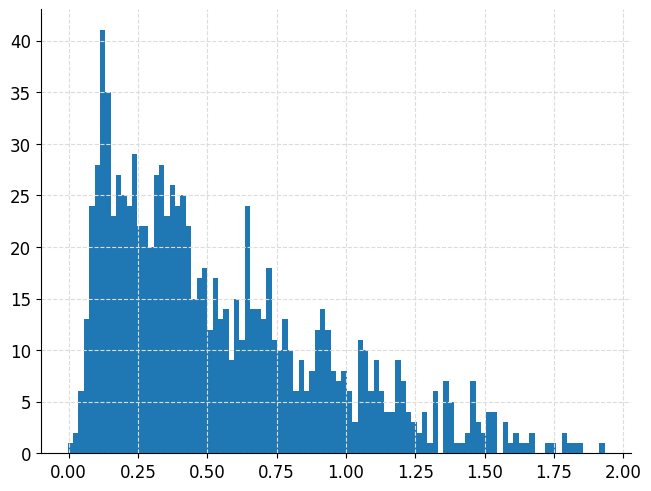

In [214]:
plt.hist(jnp.log10(M_pred_norm), 100)

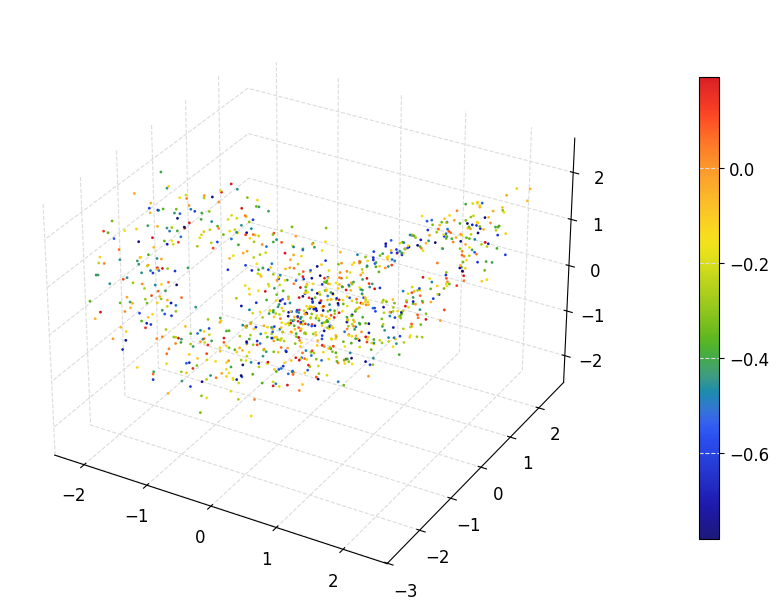

In [215]:
fig = colored_scatterplot(
    [batch[1][:, 0].T],
    [logerr],
    figsize=(10, 6),
    s=1,
    cmap=cc.cm.rainbow4,
    alpha=0.9,
)

In [147]:
du[:, 0].shape

(1024, 3, 30)

In [148]:
Z = jnp.concatenate((du[:, 0], du[:, 1]), axis=1)
Z.shape

(1024, 6, 30)

In [149]:
U, Sigma, Vh = jnp.linalg.svd(Z, full_matrices=False)

In [150]:
U.shape

(1024, 6, 6)

In [151]:
Sigma[1]

Array([0.25508711, 0.05544026, 0.03894287, 0.02566694, 0.02453656,
       0.01796355], dtype=float64)

In [152]:
Vh.shape

(1024, 6, 30)

In [153]:
Q = jnp.permute_dims(Vh[:, :2], axes=(0, 2, 1))
Q.shape

(1024, 30, 2)

In [154]:
du0_proj = jnp.matmul(du[:, 0], Q)
du1_proj = jnp.matmul(du[:, 1], Q)
du0_proj.shape

(1024, 3, 2)

In [155]:
M_tls = jnp.matmul(du1_proj, jnp.linalg.pinv(du0_proj))
M_tls2 = jnp.matmul(U[:, 3:, 0:3], jnp.linalg.pinv(U[:, 0:3, 0:3]))

In [156]:
U_r, Sigma_r, _ = jnp.linalg.svd(du[:, 0])
print(Sigma_r)

[[0.04577459 0.04110772 0.03402601]
 [0.04928771 0.04276527 0.02727034]
 [0.03996311 0.03020185 0.02762245]
 ...
 [0.03575314 0.03124144 0.02683338]
 [0.03520876 0.03337675 0.02591088]
 [0.05084038 0.04203693 0.02028814]]


In [157]:
U[:, 3:].shape

(1024, 3, 6)

In [158]:
M_tls2.shape

(1024, 3, 3)

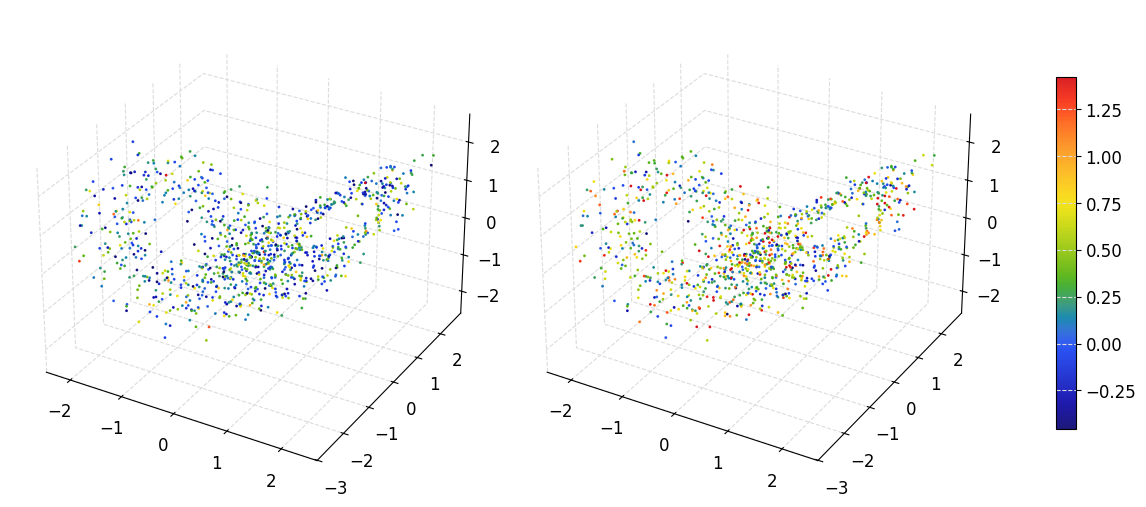

In [194]:
logerr2 = jnp.log10(
    jnp.linalg.norm(M_pred - M_tls, axis=(-2, -1), ord="fro") / M_pred_norm
)
logerr3 = jnp.log10(
    jnp.linalg.norm(M_pred - M_tls2, axis=(-2, -1), ord="fro") / M_pred_norm
)
fig = colored_scatterplot(
    [batch[1][:, 0].T] * 2,
    [logerr2, logerr3],
    figsize=(10, 6),
    s=1,
    cmap=cc.cm.rainbow4,
    alpha=0.9,
)

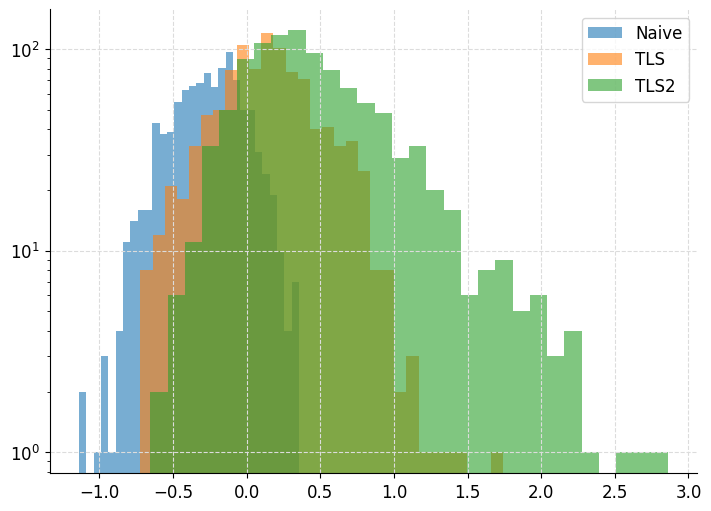

In [195]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.hist(logerr, bins=30, label="Naive", alpha=0.6)
ax.hist(logerr2, bins=30, label="TLS", alpha=0.6)
ax.hist(logerr3, bins=30, label="TLS2", alpha=0.6)
ax.legend()
ax.set_yscale("log")

In [179]:
M_true = M_pred

(array([ 69., 315., 111.,   0.,   1.,   7., 159., 231., 108.,  23.]),
 array([-7.10377874, -6.00922238, -4.91466601, -3.82010964, -2.72555327,
        -1.63099691, -0.53644054,  0.55811583,  1.6526722 ,  2.74722857,
         3.84178493]),
 <BarContainer object of 10 artists>)

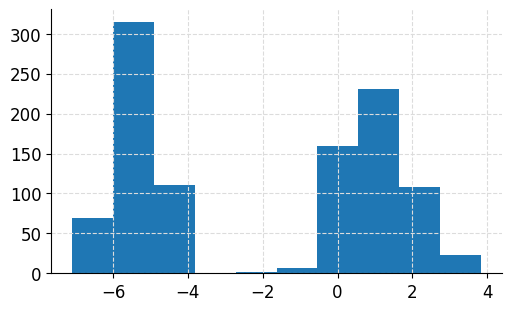

In [207]:
eig_err = (
    jnp.abs(jnp.linalg.eigvals(M_pred) - jnp.linalg.eigvals(M_tls)) ** 2
    / jnp.abs(jnp.linalg.eigvals(M_pred)) ** 2
)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(jnp.log10(jnp.abs(jnp.linalg.eigvals(M_pred)) ** 2)[:, 0])